# Homework 4

## Graphical Parameters and Model Structure

In the previous homework, you performed queries on a graphical model of possible murders and murder weapons. Now, you will estimate model parameters and structure using data.   

As a reminder, the joint probability distribution is:

$$p(B,C,W,MO,M)$$     

where the letters indicate the following variables;   
$B = $ butler committed the crime, {not murderer, murderer},   
$C = $ cook committed the crime, {not murderer, murderer},    
$W = $ choice of weapon, {poison, knife}, conditional on butler and cook,  
$MO = $motive for the murder, {no motive, has motive}, conditional on butler and cook,   
$M = $ murderer {butler or cook, third party alone}.    

We have determined that the joint distribution can be factored:

$$p(B,C,W,MO,M) = p(B)\ p(C)\ p(W\ |\ B, C)\ p(MO\ |\ B,C)\ p(M\ |\ B,C,MO,W)$$  

A graph of the model is shown below. 

<img src="MurderDirected.JPG" alt="Drawing" style="width:500px; height:300px"/>
<center> DAG for murder evidence </center>

Notice that the skeleton of this graph does not have a tree structure. This fact will limit how well estimation algorithms will work, particularly for graph structure. Keep this fact in mind as you proceed. 

As a first step execute the code in the below to simulate the 25 cases from the Bayesian directed model you have previously created. Examine the code to see the CPD tables for this simulation. 

> **Note:** You must change the name of the pickled model file in the `open` statement to match the file name you are using. 

In [1]:
## Simulate the binary tables
import numpy as np
import numpy.random as nr
import numpy as np
import pandas as pd
from pgmpy.sampling import BayesianModelSampling
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import BeliefPropagation
import pickle

## Load the model from a file
with open('murder_model.pkl', 'rb') as pkl:
    murder_model = pickle.load(pkl)
print('The model loaded correctly: {}'.format(murder_model.check_model()))

## Simulate values from the DAG
def simulate_from_DAG(model, nsamps = 25, set_seed = 234):
    nr.seed(set_seed)
    simulation = BayesianModelSampling(model)
    return(simulation.forward_sample(size = nsamps, return_type='dataframe'))


nsamps = 25
samples_25 = simulate_from_DAG(murder_model, nsamps = nsamps)
samples_25

The model loaded correctly: True


,C,B,W,MO,M
0,0,1,1,1,2
1,0,0,1,0,0
2,1,1,0,1,1
3,1,1,1,1,2
4,0,0,1,0,0
5,0,0,1,0,0
6,1,0,1,1,1
7,0,1,1,1,2
8,0,1,1,1,2
9,0,1,0,1,2


## Part 1: Parameter Estimation

With the dataset generated you will now estimate the parameters of the graphical model using both maximum likelihood and Bayesian methods. 

As a first step execute the code in the cell below to load the packages you will need.

In [2]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import BeliefPropagation
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, StructureScore

Now, create and execute the code in the cell below to estimate and display the parameters of the CPDs using the **maximum likelihood method** from the simulated graphy data.

In [3]:
m_model = BayesianModel([('B', 'MO'), ('B', 'W'), ('B', 'M'),('C', 'MO'), ('C', 'W'), ('C', 'M'), ('W', 'M'), ('MO', 'M')])
m_model.fit(samples_25, estimator=MaximumLikelihoodEstimator)
for cpd in m_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of B:
+------+-----+
| B(0) | 0.4 |
+------+-----+
| B(1) | 0.6 |
+------+-----+
CPD of C:
+------+------+
| C(0) | 0.64 |
+------+------+
| C(1) | 0.36 |
+------+------+
CPD of M:
+------+--------------------+-------+--------------------+--------------------+-------+-------+--------------------+-------+--------------------+--------------------+-------+-------+--------------------+--------------------+-------+-------+
| B    | B(0)               | B(0)  | B(0)               | B(0)               | B(0)  | B(0)  | B(0)               | B(0)  | B(1)               | B(1)               | B(1)  | B(1)  | B(1)               | B(1)               | B(1)  | B(1)  |
+------+--------------------+-------+--------------------+--------------------+-------+-------+--------------------+-------+--------------------+--------------------+-------+-------+--------------------+--------------------+-------+-------+
| C    | C(0)               | C(0)  | C(0)               | C(0)               | C(1)  | C(1)

Examine these results and answer the following questions:
1. How many parameters are there in the CPD tables?
2. Keeping in mind that the probability of each column in a CPT must add to 1, how many free parameters must be fit for this model. 
3. Given the number of parameters, and the sample size of 25 cases, is this MLE problem under-determined and why? 
4. Notice the number of 0.0 and 1.0 parameter values. Is this evidence of an under-fit model, and why? 

ANS 1:  68    
ANS 2:  42      
ANS 3:  yes it is underdetermined, since there are more parameters than data points 
ANS 4:  yes, this is evidence of an underfit model since no outcome should be absolutely certain

Next, you will estimate the CPD parameters using a **Bayesian estimator**. For this first estimate use the following moderately weak and uniform prior distributions (pseudo counts):

- C: [3,3]
- B: [3,3]
- W: [[3,3,3,3], [3,3,3,3]]
- MO: [[3,3,3,3], [3,3,3,3]]
- M: [[2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2], [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2], [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]]

In the cell below create and execute the code to perform Bayes estimation and display the CPD parameters. 

In [4]:
bayes_m_model = BayesianModel([('B', 'MO'), ('B', 'W'), ('B', 'M'),('C', 'MO'), ('C', 'W'), ('C', 'M'), ('W', 'M'), ('MO', 'M')])

# Learing CPDs using Bayesian Estimators
pseudo_counts = {'C': [[3],[3]], 'B':[[3],[3]], 'W':[[3,3,3,3],[3,3,3,3]], 'MO':[[3,3,3,3],[3,3,3,3]], 'M':[[2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2], [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2], [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]]}
bayes_m_model.fit(samples_25, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=pseudo_counts)
for cpd in bayes_m_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of B:
+------+----------+
| B(0) | 0.419355 |
+------+----------+
| B(1) | 0.580645 |
+------+----------+
CPD of MO:
+-------+------+------+--------+--------------------+
| B     | B(0) | B(0) | B(1)   | B(1)               |
+-------+------+------+--------+--------------------+
| C     | C(0) | C(1) | C(0)   | C(1)               |
+-------+------+------+--------+--------------------+
| MO(0) | 0.75 | 0.5  | 0.1875 | 0.2727272727272727 |
+-------+------+------+--------+--------------------+
| MO(1) | 0.25 | 0.5  | 0.8125 | 0.7272727272727273 |
+-------+------+------+--------+--------------------+
CPD of W:
+------+------+------+--------+---------------------+
| B    | B(0) | B(0) | B(1)   | B(1)                |
+------+------+------+--------+---------------------+
| C    | C(0) | C(1) | C(0)   | C(1)                |
+------+------+------+--------+---------------------+
| W(0) | 0.25 | 0.4  | 0.3125 | 0.6363636363636364  |
+------+------+------+--------+---------------------+
| W(1

Focus your attention on the M and W CPDs. In terms of extreme values, how does the table computed with the Bayesian method compare to the table computed with MLE? Is this behavior evidence of the regularization property of the Bayesian estimator. 

ANS 1: The tables generated by the bayesian method do not contain any extreme values such as 1 or 0 as compared to the tables generated with MLE method.     
ANS 2: The Bayesian method avoids these extreme values by using regularization to constrain the probabilities.

Next verify that the independencies of all the variables in your model are correct using the `local_independencies` method. Create and execute the code in the cell below to display the independencies in the CPD. 

In [5]:
bayes_m_model.local_independencies(['B','C','W','MO','M'])

(B _|_ C)
(C _|_ B)
(W _|_ MO | C, B)
(MO _|_ W | C, B)

**Question:** Is your graph an I-map of the factorized distribution and why?

ANS: Yes, the graphical model is an I-map since all of the independencies depicted in the graphical model are also part of the original factorized distribution.

Now you are ready to perform inference on your model. Use the belief propagation method to query the M. 

In [6]:
from pgmpy.inference import BeliefPropagation
m_belief = BeliefPropagation(bayes_m_model)
m_b_prior_q = m_belief.query(variables=['M'])
print(m_b_prior_q['M'])

+-----+----------+
| M   |   phi(M) |
+=====+==========+
| M_0 |   0.3115 |
+-----+----------+
| M_1 |   0.2838 |
+-----+----------+
| M_2 |   0.4047 |
+-----+----------+


C:\ProgramData\Anaconda3\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:586: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi.values = phi.values[slice_]
C:\ProgramData\Anaconda3\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:598: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi1.values = phi1.values[slice_]


Compare this resulting marginal distribution to the marginal distribution you obtained for the same query in the previous homework using the CDP tables provided. How do these distribution differ?

ANS: The original has higher probability for M_2 by more than .1, while the probabilties for M_0 and M_1 are lower in the original. The relative order of distribution is the same for both.

Next, you will estimate the CPD parameters using the Bayesian estimator with a moderately weak but biased prior distribution. Such a prior distribution can be constructed from some combination of data from previous murder cases and the opinions of several investigators (experts). For this first estimate use the following prior distributions (pseudo counts):

- C: [[8], [2]]
- B: [[2],[8]]
- W: [[2,4,2,3], [4,2,4,3]]
- MO: [[3,2,4,3], [3,4,2,3]]
- M: [[1,1,1,1,4,4,4,4,1,1,1,1,2,2,2,2], [1,1,1,1,1,1,1,1,4,4,4,4,2,2,2,2], [4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1]]

In the cell below create and execute the code to perform Bayes estimation and display the CPD parameters. 

In [7]:
bayes_m_model = BayesianModel([('B', 'MO'), ('B', 'W'), ('B', 'M'),('C', 'MO'), ('C', 'W'), ('C', 'M'), ('W', 'M'), ('MO', 'M')])

# Learing CPDs using Bayesian Estimators
pseudo_counts = {'C': [[8], [2]], 'B':[[2],[8]], 'W':[[2,4,2,3], [4,2,4,3]], 'MO': [[3,2,4,3], [3,4,2,3]], 'M':[[1,1,1,1,4,4,4,4,1,1,1,1,2,2,2,2], [1,1,1,1,1,1,1,1,4,4,4,4,2,2,2,2], [4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1]]}
bayes_m_model.fit(samples_25, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=pseudo_counts)
for cpd in bayes_m_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of B:
+------+----------+
| B(0) | 0.342857 |
+------+----------+
| B(1) | 0.657143 |
+------+----------+
CPD of MO:
+-------+------+------+------+--------------------+
| B     | B(0) | B(0) | B(1) | B(1)               |
+-------+------+------+------+--------------------+
| C     | C(0) | C(1) | C(0) | C(1)               |
+-------+------+------+------+--------------------+
| MO(0) | 0.75 | 0.4  | 0.25 | 0.2727272727272727 |
+-------+------+------+------+--------------------+
| MO(1) | 0.25 | 0.6  | 0.75 | 0.7272727272727273 |
+-------+------+------+------+--------------------+
CPD of W:
+------+---------------------+------+------+---------------------+
| B    | B(0)                | B(0) | B(1) | B(1)                |
+------+---------------------+------+------+---------------------+
| C    | C(0)                | C(1) | C(0) | C(1)                |
+------+---------------------+------+------+---------------------+
| W(0) | 0.16666666666666666 | 0.5  | 0.25 | 0.6363636363636364  |

Compare the parameters tables computed with the biased prior to those estimated with a uniform prior. How are these different, and is this expected given the change in prior?

ANS: The parameter tables computed with biased prior weigh the probabilities more heavily towards those parameter values with stronger priors as compared to the uniform priors.

But, how much does the prior matter in terms of inference? Use the belief propagation method to query the M variable and display the results.  

In [8]:
m_belief = BeliefPropagation(bayes_m_model)
m_b_prior_q = m_belief.query(variables=['M'])
print(m_b_prior_q['M'])

+-----+----------+
| M   |   phi(M) |
+=====+==========+
| M_0 |   0.2685 |
+-----+----------+
| M_1 |   0.3279 |
+-----+----------+
| M_2 |   0.4036 |
+-----+----------+


Compare this marginal distribution to the one obtained with the a uniform prior. Would you say these differences are significant, and why?

ANS:Numeric values are only slightly different between the two cases while maintaining the same order.

Perhaps more data will improve the estimation of the model parameters, particularly for the maximum likelihood method. In the cell below compute a new data set with 250 cases. Use a random seed value of 5678. Be sure to give your new data frame a different name. 

In [9]:
nsamps = 250
samples_250 = simulate_from_DAG(murder_model, nsamps = nsamps, set_seed = 5678)
samples_250

,C,B,W,MO,M
0,0,0,0,0,0
1,0,1,1,1,2
2,0,1,1,1,2
3,0,1,0,1,2
4,0,0,1,0,0
5,0,0,1,0,0
6,0,1,0,1,2
7,0,1,0,1,2
8,0,1,1,1,2
9,0,1,0,1,2


Now, compute the model parameters using the 250 sample dataset and the **maximum likelihood estimator**.

In [10]:
m_model.fit(samples_250, estimator=MaximumLikelihoodEstimator)
for cpd in m_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of B:
+------+-------+
| B(0) | 0.444 |
+------+-------+
| B(1) | 0.556 |
+------+-------+
CPD of C:
+------+-----+
| C(0) | 0.7 |
+------+-----+
| C(1) | 0.3 |
+------+-----+
CPD of M:
+------+-------+-------+--------------------+--------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+---------------------+-------+
| B    | B(0)  | B(0)  | B(0)               | B(0)               | B(0)  | B(0)  | B(0)  | B(0)  | B(1)  | B(1)  | B(1)  | B(1)  | B(1)  | B(1)  | B(1)                | B(1)  |
+------+-------+-------+--------------------+--------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+---------------------+-------+
| C    | C(0)  | C(0)  | C(0)               | C(0)               | C(1)  | C(1)  | C(1)  | C(1)  | C(0)  | C(0)  | C(0)  | C(0)  | C(1)  | C(1)  | C(1)                | C(1)  |
+------+-------+-------+--------------------+--------------------+-------+-------+-------+-------+----

Compare these results to the MLE results you computed with 25 data cases. Are their fewer extreme values? But, does the presence of extreme values still indicate the model is under-fit despite an order of magnitude increase in the number of data cases? 

ANS 1: Yes, there are fewer extreme values in these CPDs.

ANS 2: Yes, the presence of extreme values indicates that this model is still under-fit.

Next, you will compare the MLE values to those produced by the **Bayesian estimator** using the same uniform prior as the first Bayes estimate. 

In [11]:
pseudo_counts = {'C': [[3],[3]], 'B':[[3],[3]], 'W':[[3,3,3,3],[3,3,3,3]], 'MO':[[3,3,3,3],[3,3,3,3]], 'M':[[2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2], [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2], [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]]}
m_model.fit(samples_250, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=pseudo_counts)
for cpd in m_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of B:
+------+----------+
| B(0) | 0.445312 |
+------+----------+
| B(1) | 0.554688 |
+------+----------+
CPD of C:
+------+----------+
| C(0) | 0.695312 |
+------+----------+
| C(1) | 0.304688 |
+------+----------+
CPD of M:
+------+-------+---------------------+--------------------+--------------------+---------------------+---------------------+-------+---------------------+--------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------+
| B    | B(0)  | B(0)                | B(0)               | B(0)               | B(0)                | B(0)                | B(0)  | B(0)                | B(1)               | B(1)                | B(1)                | B(1)                | B(1)                | B(1)                | B(1)                | B(1)  |
+------+-------+---------------------+--------------------+--------------------+---------------------+---------------------+-------+------

In terms of evidence of under-fitting, such as repeated parameter values, how does these estimates compare to the Bayes estimates using 25 cases? Also, are probability tables for the butler and the cook closer to the original values from DAG model used for the simulation, when compare to the parameters computed with the Bayes estimator from 25 cases? 

ANS 1: Yes the incidence of repeated values is lower for this case than for the 25 value case, indicating an improvement in the under-fitting.

ANS 2: Yes, the probability tables for the cook and butler are now closer to their actual values.

### Bayesian Estimation of Parameters

To gain a feel for how a prior distribution changes the parameter estimates you will perform random sampling of data from the DAG model and estimate a model parameter. As a first step, write a function(s) that random samples a dataset and then estimates the parameter, $\theta$. Your function(s) should do the following:

1. Use the DAG model you imported for the simulation creating each dataset realization. 
2. Arguments should include the $\alpha$ and $\beta$ prior pseudo counts.
3. The parameter, $\theta$ is estimated for the butler, B, table. 
4. The number of samples per realized dataset is 25. 
5. Compute 1,000 estimates of $\theta$, using 1,000 independent sample datasets.
6. Use an initial random seed of 345, and increase your seed value by 100 for each realization.
7. Return an array-like data structure containing your 1,000 parameter estimates. 

Create the code in the cell below. Then execute your code for a **maximum likelihood estimate** of the 1,000 values of theta by setting $\alpha$ and $\beta$ both to 0, and save the results. 

In [22]:
def estimate_theta(model, alpha, beta, num_samples, num_estimates, random_seed):
    estimates = []
    for i in range(num_estimates):
        curr_samples = simulate_from_DAG(model, num_samples, set_seed = random_seed)
        numerator = sum(curr_samples['B']) + alpha
        denominator = num_samples + alpha + beta
        estimates.append(numerator/float(denominator))
        random_seed = random_seed + 100
    return estimates

mle_thetas = estimate_theta(m_model, 0, 0, 25, 1000, 345)

The next step is to visualize the results as a histogram. Create a function to plot a histogram with of your parameter estimates using 50 bins and with x-axis limits of (0.2,0.9). Make sure to label your axes. Then, plot the histogram and examine the results. 

> **Note:** Since the DAG has a limited number of discrete valued notes, expect the histogram to have a number of discrete values.

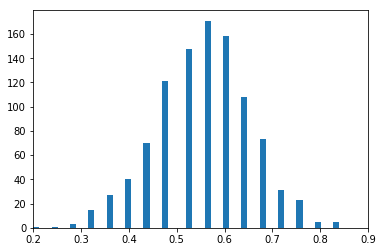

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_hist(data):
    plt.hist(data, bins = 50)
    plt.xlim((0.2,0.9))
    
plot_hist(mle_thetas)

Examine the dispersion of the parameter estimates and the most likely value (mode). Given that the parameter, $\theta$, must be in the range $0.0 \le \theta \le 1.0$, would you say there is significant dispersion in these estimates, and why? 

ANS: Yes, there is quite a bit of dispersion since values are present along the entire x-axis. This is probably because there is no prior.

Next, simulate a new realization of the 1,000 datasets, estimating the parameters, $\theta$ using a prior with pseudo counts, alpha = 6, beta = 4. Then, plot the histogram to compare with the previous results. 

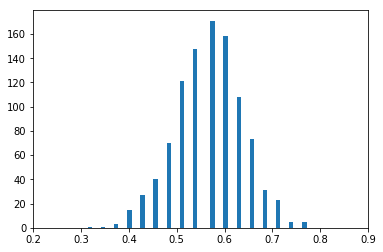

In [24]:
prior_thetas = estimate_theta(m_model, 6, 4, 25, 1000, 345)
plot_hist(prior_thetas)
#prior_thetas

How has adding this prior changed the characteristics of the distribution of the parameter, $\theta$?

ANS: The dispersion for this set of values is less than before with the mode remaining the same.

Now, you will explore the learning properties of the Bayes estimator when very little data is available. You will compute realizations of datasets with just 5 samples and plot the histogram of the parameter estimates. Continue using a prior with pseudo counts, alpha = 6, beta = 4. 

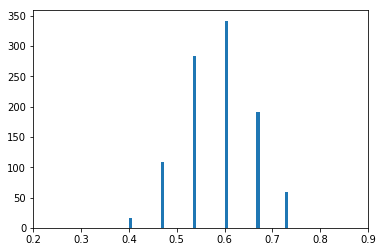

In [25]:
prior_thetas = estimate_theta(m_model, 6, 4, 5, 1000, 345)
plot_hist(prior_thetas)

Examine the resulting histogram. The result has fewer discrete values that the histogram computed using a sample size of 25. But, are the dispersion and mode of these two distributions nearly the same and why? 

ANS:The dispersion is the same since alpha and beta are the same, but there are fewer discrete values since the number of samples per run is much lower.

Finally, you will investigate the effect of a strong prior. A strong prior arises in cases where there is considerable experience with the problem. In such cases, the new observations only incrementally change the parameter estimates. 

Simulate a new realization of datasets with 25 samples each, estimating the parameters, $\theta$ using a prior with pseudo counts, alpha = 16, beta = 24. Then, plot the histogram to compare with the previous results. 

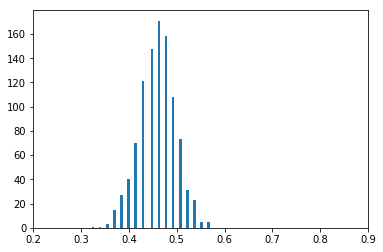

In [26]:
prior_thetas = estimate_theta(m_model, 16, 24, 25, 1000, 345)
plot_hist(prior_thetas)

Compare these results to the those obtained using the same prior with 25 samples per realization. What are the key differences between these distributions of the parameters, and why? 

ANS:The dispersion for this case is much lower and the mode has shifted to the left because of the strong prior.

## Part 2, Learning Structure

Now you will explore how well the structure of the graph can be estimated. **Keep in mind that the graph used for the simulation is not a tree**. Answer the questions based on the results you find. 

With the dataset simulated, you will now try estimating the model structure. Use the hill climb search algorithm with the BIC scoring function to estimate the model structure, using the dataset with 250 samples. Set a `numpy.random.seed` of 5566, before computing the model. Create and execute the code in the cell below to estimate the model structure and display the identified edges. 

In [27]:
nr.seed(5566) 
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, StructureScore
from pgmpy.models import BayesianModel
est_bic = HillClimbSearch(samples_250, scoring_method=BicScore(samples_250))
BIC_edges = est_bic.estimate(max_indegree=2).edges()
BIC_edges

[('B', 'M'), ('M', 'C'), ('M', 'MO'), ('M', 'W')]

Examine these edges. How does this model compare to the model used to simulate the data?

ANS: This model differs quite a bit from the original model, only edges between M and other variables are present in this model. 

How good is this structure fit? To answer this question you will need to compare the BIC score of the graph used for the simulation with the BIC score of the estimated structure. You must create a baseline DAG structure and compare the BIC score to the score of the estimated model. 

Notice that in practice, you will never know the true graph structure. Else, why estimate it? In such cases, the best you can do is test several models and select the one with the lowest BIC that also honors any constraints known from expert opinion. 

In the cell below create the code to compute and display the BIC score of both the graph used for the simulation and the estimated structure, using the 250 sample dataset.

In [28]:
print(BicScore(samples_250).score(m_model))
print(BicScore(samples_250).score(BayesianModel(BIC_edges)))

-691.4378654542542
-625.4589810490882


Are these BIC scores different and what does this mean in terms of how good the estimated model is? 

ANS: Yes, the bic scores are different, the original model has a better score since it is lower.  

Next, you will apply the K2 score method to the 250 case dataset. In the cell below, create the code to use the hill climbing search with the K2 score to estimate and display the model structure. Set a `numpy.random.seed` of 6565, before computing the model. 

In [29]:
nr.seed(6565)
est_K2S = HillClimbSearch(samples_250, scoring_method=K2Score(samples_250))
K2S_edges = est_K2S.estimate(max_indegree=2).edges()
K2S_edges

[('C', 'M'), ('C', 'W'), ('B', 'MO'), ('M', 'B'), ('M', 'MO'), ('M', 'W')]

Is this graph structure any different from the one obtained with the BIC score and what does this mean in terms of the independency structure?

ANS:This graph structure looks a little better than the one obtained from BIC score, it captures more of the edges from the original graph, but still differs significantly from the original graph.

Now, compare the K2 score for the baseline DAG model with the estimated model using the 250 case dataset. In the cell below create and execute the code to compute and display these scores. 

In [30]:
print(K2Score(samples_250).score(m_model))
print(K2Score(samples_250).score(BayesianModel(K2S_edges)))

-655.6480031340966
-622.8204332522461


Are these K2 scores different and what does this indicate about the estimated model? 

ANS:Yes, the K2 scores are different, the original model has a better score since it is lower. 

In the cell below create and execute the code to display the independencies of the graph structure you have found. 

In [31]:
est_K2S.estimate().local_independencies(['B', 'C', 'W', 'MO', 'M'])

(B _|_ C | M)
(W _|_ MO, M | C, B)
(MO _|_ W, M | C, B)

Notice that these local independencies have some problematic characteristics. What statement can you make about these problems for the murderer variable, M?

ANS: It doesn't make sense for weapon and motive to be independent of the murderer, since the different values for murderers have different probabilities for each of the values of weapon and motive.

Perhaps, a larger dataset will yield better DAGs? In the cell below, compute a dataset with 25,000 samples using the DAG model. Use a random seed of 9898. 

In [32]:
samples_25000 = simulate_from_DAG(m_model, nsamps = 25000, set_seed = 9898)

With the larger dataset available, you can now determine if using 2 orders of magnitude more data improves the model structure estimates. In the cell below, use the hill climb search algorithm with the BIC scoring function to estimate the model structure. Set a `numpy.random.seed` of 4567, before computing the model. Make sure you give you model a unique name so you can make comparisons latter.

In [33]:
nr.seed(4567)
est_bic_big = HillClimbSearch(samples_25000, scoring_method=BicScore(samples_25000))
BIC_edges_big = est_bic_big.estimate(max_indegree=2).edges()
BIC_edges_big

[('C', 'MO'),
 ('C', 'B'),
 ('B', 'MO'),
 ('W', 'M'),
 ('W', 'C'),
 ('M', 'B'),
 ('M', 'C')]

Next, use the 25,000 sample data set with the hill climb search algorithm using the K2 scoring function to estimate the model structure. Set a `numpy.random.seed` of 765, before computing the model. Make sure you give you model a unique name so you can make comparisons latter.

In [34]:
nr.seed(765)
est_K2S_big = HillClimbSearch(samples_25000, scoring_method=K2Score(samples_25000))
K2S_edges_big = est_K2S_big.estimate(max_indegree=2).edges()
K2S_edges_big

[('C', 'M'), ('C', 'MO'), ('C', 'W'), ('B', 'M'), ('B', 'MO'), ('M', 'W')]

The two scoring methods have arrived at different models, even when a larger dataset is used.  What are some key differences in these models and with the original models? **Hint:** Look at the numbers of directed edges.

ANS: With the larger sample, the BIC scoring method yields 3 more edges in the graph, whereas the number of edges from the K2 score remain the same. The graph from the K2 score method still appears more reasonable as compared to the original graph.

The K2 score models have been created using a Dirichlet uniform prior, starting with a completely unconnected model. See the [pgmpy documentation for more details](http://pgmpy.org/estimators.html).   

The addition of a prior in the form of an initial DAG model might make a difference. In the cell below a simple initial model is defined. You can specify an initial model using the `start` argument to the `estimate` method. 

Using the 25,000 case dataset and the initial model, use the K2 score to find a model structure. Set a `numpy.random.seed` of 543, before computing the model. Make sure you give you model a unique name so you can make comparisons latter.

In [35]:
## Define the initial network structure.
start = BayesianModel([('W','M'), ('MO','M'), ('B',"M"), ('C',"M")])

## Define code and find model structure
est_K2S_prior = HillClimbSearch(samples_25000, scoring_method=K2Score(samples_25000))
K2S_edges_prior = est_K2S_prior.estimate(max_indegree=2, start=start).edges()
K2S_edges_prior

[('W', 'M'),
 ('MO', 'M'),
 ('B', 'M'),
 ('B', 'MO'),
 ('B', 'W'),
 ('C', 'M'),
 ('C', 'MO'),
 ('C', 'W')]

Has the use of the prior or initial model changed the result? 

ANS: Yes, using the prior gives us the a model that matches the original model exactly.

Finally, compare the BIC and K2 scores of the three models you created with the K2 and BIC score methods on the 25,000 case dataset. In the cell below create and execute the code to compute and display these 6 scores.  

In [36]:
print(BicScore(samples_250).score(BayesianModel(BIC_edges_big)))
print(K2Score(samples_250).score(BayesianModel(BIC_edges_big)))
print(BicScore(samples_250).score(BayesianModel(K2S_edges_big)))
print(K2Score(samples_250).score(BayesianModel(K2S_edges_big)))
print(BicScore(samples_250).score(BayesianModel(K2S_edges_prior)))
print(K2Score(samples_250).score(BayesianModel(K2S_edges_prior)))

-634.9618377603881
-629.4229755578021
-632.9192682113727
-628.4516134472877
-691.4378654542542
-655.6480031340967


Examine these results. Do the results indicate any one model is substantially better than the others? Does this outcome help explain the ambiguity you have seen in estimating model structure, and why? 

ANS 1: Yes, the model with the prior using K2 score is substantially better than the others.
ANS 2: Yes, these results show that if the search for the model structure is constrained, such as with a prior, the search can derive much better results.

Finally, create and execute the code in the cell below, to print the local independencies of the models estimated using the K2 and BIC score methods on the 25,000 case dataset.

In [39]:
print(est_bic_big.estimate().local_independencies(['B', 'C', 'W', 'MO', 'M']))
print('\n')
print(est_K2S_big.estimate().local_independencies(['B', 'C', 'W', 'MO', 'M']))
print('\n')
print(est_K2S_prior.estimate().local_independencies(['B', 'C', 'W', 'MO', 'M']))

(MO _|_ W | C, M, B)


(B _|_ C)
(C _|_ B)
(W _|_ MO | C, B)
(MO _|_ W | C, B)


(B _|_ C)
(C _|_ B)
(W _|_ MO | C, B)
(MO _|_ W | C, B)


How are the local indepenencies different? Which structure makes more sense when compared to the original DAG used for the simulation?

ANS 1: The models using the K2 score and K2 score with prior reveal 4 local independencies while the model using the BIC score shows only one local independency.
ANS 2: The models using the K2 score make more sense since they capture the actual independencies from the original DAG.